In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, OrdinalEncoder
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv", index_col="PassengerId")
test_data = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv", index_col="PassengerId")
train_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
PassengerId,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [3]:
test_data.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
PassengerId,,,,,,,,,,,,
0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


In [4]:
print(train_data.shape, test_data.shape)

(8693, 13) (4277, 12)


In [5]:
num_cols = ["Age", "RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
byn_cols = ["CryoSleep","VIP"]
cat_cols = ["HomePlanet", "Destination"]
del_cols = ["Cabin", "Name"]

In [6]:
X = train_data.copy()
X.drop(del_cols, axis=1, inplace=True)
y = X.pop("Transported")
X.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
PassengerId,,,,,,,,,,
0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0
0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0
0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0
0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0
0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0


In [7]:
def summary(df):
    summ = pd.DataFrame(df.dtypes, columns=['dtypes'])
    summ['missing#'] = df.isna().sum().values*100
    summ['missing%'] = (df.isna().sum().values*100)/len(df)
    summ['uniques'] = df.nunique().values
    summ['count'] = df.count().values
    desc = pd.DataFrame(df.describe().T)
    summ['min'] = desc['min']
    summ['max'] = desc['max']
    summ['mean'] = desc['mean']
    return summ

summary(X).style.background_gradient(cmap='Blues')

,dtypes,missing#,missing%,uniques,count,min,max,mean
HomePlanet,object,20100,2.312205,3,8492,nan,nan,nan
CryoSleep,object,21700,2.496261,2,8476,nan,nan,nan
Destination,object,18200,2.093639,3,8511,nan,nan,nan
Age,float64,17900,2.059128,80,8514,0.000000,79.000000,28.827930
VIP,object,20300,2.335212,2,8490,nan,nan,nan
RoomService,float64,18100,2.082135,1273,8512,0.000000,14327.000000,224.687617
FoodCourt,float64,18300,2.105142,1507,8510,0.000000,29813.000000,458.077203
ShoppingMall,float64,20800,2.392730,1115,8485,0.000000,23492.000000,173.729169
Spa,float64,18300,2.105142,1327,8510,0.000000,22408.000000,311.138778
VRDeck,float64,18800,2.162660,1306,8505,0.000000,24133.000000,304.854791


/tmp/ipykernel_20/209356259.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = X[num].corr()


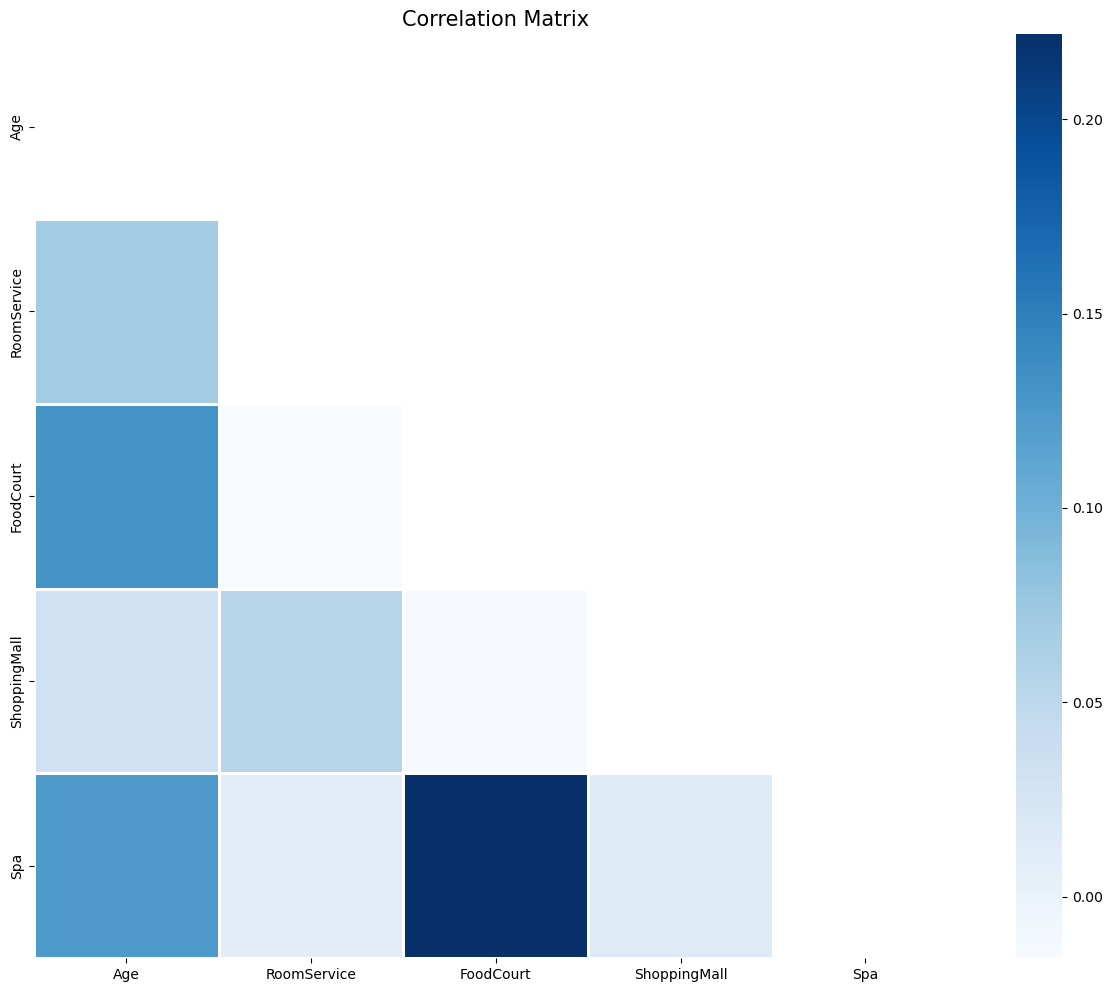

In [8]:
num = X.columns.tolist()[1:-1]
corr_matrix = X[num].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='Blues', fmt='.2f', linewidths=1, square=True, annot_kws={"size": 9} )
plt.title('Correlation Matrix', fontsize=15)
plt.show()

In [9]:
cat_pipeline = Pipeline(steps=
                         [('imputer',SimpleImputer(strategy="most_frequent")),
                          ('onehot', OneHotEncoder(handle_unknown='ignore')),
                          ])

num_pipeline = Pipeline(steps=
                         [('imputer',KNNImputer(n_neighbors=5)),
                          ('scaler', MinMaxScaler()),
                          ])
byn_pipeline = Pipeline(steps=
                      [('binary_encoder', OneHotEncoder(drop='if_binary'))
                      ])
preprocessor = ColumnTransformer(
    transformers=[
        ('num',num_pipeline,num_cols),
        ('cate',cat_pipeline,cat_cols),
        ('byn', byn_pipeline, byn_cols )
    ]
)

param_grid = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__learning_rate': [0.01, 0.1, 0.2],
    'classifier__max_depth': [3, 4, 5],
}

clf = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", XGBClassifier())
    ]
)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=3, scoring='accuracy')

In [10]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [11]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          KNNImputer()),
                                                                                         ('scaler',
                                                                                          MinMaxScaler())]),
                                                                         ['Age',
                                                                          'RoomService',
                                                                          'FoodCourt',
                                                                          'ShoppingMall',
                                                                          'Spa',
                                                                          'VRDeck']),
                                                                        ('cate',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(handle_unknown='i...
                                                      max_delta_step=None,
                                                      max_depth=None,
                                                      max_leaves=None,
                                                      min_child_weight=None,
                                                      missing=nan,
                                                      monotone_constraints=None,
                                                      n_estimators=100,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      predictor=None,
                                                      random_state=None, ...))]),
             param_grid={'classifier__learning_rate': [0.01, 0.1, 0.2],
                         'classifier__max_depth': [3, 4, 5],
                         'classifier__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [12]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

In [13]:
accuracy = best_model.score(X_valid, y_valid)
print(accuracy)

0.7929844738355377


In [14]:
from sklearn.metrics import accuracy_score
y_train_pred = best_model.predict(X_train)
print(f"Accuracy on train: {accuracy_score(list(y_train), list(y_train_pred)):.2f}")

y_pred = best_model.predict(X_valid)
print(f"Accuracy on test: {accuracy_score(list(y_valid), list(y_pred)):.2f}")

Accuracy on train: 0.83
Accuracy on test: 0.79


In [15]:
X_test = test_data.copy()
X_test.drop(del_cols, axis=1, inplace=True)
submition = best_model.predict(X_test)

In [16]:
output = pd.DataFrame({'PassengerId': X_test.index,
                       'Transported': submition})
output['Transported'] = output['Transported'].apply(lambda x:True if x==1 else False)
output.to_csv('submission.csv', index=False)

In [17]:
output.head()

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
